In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper

In [3]:
# 0. random data.  price is endogenous, instrument is this 
n = 10000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

In [4]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4


In [5]:
print(ivsim.exog_x_cols, ivsim.endog_x_col, ivsim.instrument_col, ivsim.y_col)
display(ivsim.log_cost_coefs)
display(ivsim.log_sales_coefs)
display(df.describe())

['x_0', 'x_1'] log_price instrument log_sales


x_0    0.707107
x_1    0.707107
dtype: float64

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.018369,0.001719,-3.998095,0.014204,0.424120,0.000942,0.425062,-1.263862,4999.50000
std,1.003899,0.996794,1.609220,1.013633,1.058928,0.057623,1.060207,3.620433,2886.89568
min,-3.801378,-3.685499,-6.798997,-3.492599,-3.127753,-0.099983,-3.132122,-17.948572,0.00000
25%,-0.666906,-0.686832,-5.394813,-0.676062,-0.306594,-0.048520,-0.304092,-3.116390,2499.75000
50%,0.014632,0.009468,-4.007687,0.001468,0.411439,0.001735,0.409161,-1.363713,4999.50000
75%,0.683905,0.681603,-2.616799,0.696894,1.137529,0.050727,1.136885,0.653906,7499.25000
max,3.676205,4.068097,-1.200855,3.628798,4.165641,0.099975,4.088933,14.160886,9999.00000


In [6]:
# 4. now compute some true quantiles
log_price_qtl_cols = []
interval = .1
qtls = np.arange(0,1,interval) + interval/2
print("computing these conditional quantiles of log price: {}".format(qtls))
for qtl in qtls:
    qcol = 'log_price_qtl_{:.3f}'.format(qtl)
    df[qcol] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], df['instrument'], qtl)
    log_price_qtl_cols.append(qcol)
print("these are the relevant columns: {}".format(log_price_qtl_cols))

computing these conditional quantiles of log price: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]
these are the relevant columns: ['log_price_qtl_0.050', 'log_price_qtl_0.150', 'log_price_qtl_0.250', 'log_price_qtl_0.350', 'log_price_qtl_0.450', 'log_price_qtl_0.550', 'log_price_qtl_0.650', 'log_price_qtl_0.750', 'log_price_qtl_0.850', 'log_price_qtl_0.950']


In [7]:
# 5. construct data for doing deepiv with these true quantiles
#    this will involve just duplicating the data a bunch of times,
#    each time for each quantile of log price
dfs_to_concat = []
for c in log_price_qtl_cols:
    tmp_df = df[['id']+ivsim.exog_x_cols+[c]+[ivsim.y_col]].rename(columns={c:'log_price_synthetic'})
    dfs_to_concat.append(tmp_df)
df_long = pd.concat(dfs_to_concat).reset_index(drop=True)

In [8]:
# 6. check linear custom objective still works here just to be sure
from scipy.optimize import minimize
# now actually optimize it. takes maybe a minute to finish?
tmp_xcols = ivsim.exog_x_cols+['log_price_synthetic']
min_output = minimize(fun = custom_objectives.grouped_sse_loss_linear, 
                      x0=np.zeros(shape=len(tmp_xcols)+1), 
                      args = (df_long, tmp_xcols, ivsim.y_col, 'id'))
# compare with truth.  doesn't look too bad.
pd.DataFrame({'true coefs': ivsim.log_sales_coefs, 'linear NPIV coefs':min_output.x[1:]})

,true coefs,linear NPIV coefs
x_0,0.707107,0.536132
x_1,0.707107,0.514787
log_price,-4.000000,-3.770611


In [9]:
print(df_long.columns)
print(df_long.shape, len(df_long['id'].unique()))
display(df_long.tail())

Index(['id', 'x_0', 'x_1', 'log_price_synthetic', 'log_sales'], dtype='object')
(100000, 5) 10000


,id,x_0,x_1,log_price_synthetic,log_sales
99995,9995,0.908597,0.720665,2.305681,-2.297293
99996,9996,0.409403,0.478726,1.754225,-1.954046
99997,9997,0.837064,-0.947254,0.959748,-1.695108
99998,9998,-0.258611,-1.402840,-0.055182,-1.762586
99999,9999,1.044541,0.369281,2.149036,-7.521199


In [10]:
# divide into train/val/test
train_cutoff = int(n*.5)
val_cutoff = int(n*.7)
df_train = df_long.loc[df_long['id']<train_cutoff, :]
df_val = df_long.loc[(df_long['id']>=train_cutoff)&(df_long['id']<val_cutoff), :]
df_test = df.loc[df['id']>=val_cutoff, :].rename(columns={'log_price':'log_price_synthetic'})
print(df_train.shape, df_val.shape, df_test.shape)

(50000, 5) (20000, 5) (3000, 19)


In [11]:
# construct lgb.datasets for prediction
x_cols = ivsim.exog_x_cols + ['log_price_synthetic']
y_col = ivsim.y_col
print(x_cols, y_col)

dat_train = lgb.Dataset(df_train[x_cols], label=df_train[y_col])
dat_train.grouper = df_train['id']
dat_val = lgb.Dataset(df_val[x_cols], label=df_val[y_col])
dat_val.grouper = df_val['id']


['x_0', 'x_1', 'log_price_synthetic'] log_sales


# try the upper bound objective = just l2

In [22]:
# try training
num_iters=10000
params = {
    'num_threads':4,
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}
eval_results = {}
gbm1 = lgb.train(params, train_set=dat_train, valid_sets=[dat_train, dat_val], valid_names=['train', 'val'],
                num_boost_round=num_iters, verbose_eval=500,
                callbacks=[lgb.record_evaluation(eval_results)])

[500]	train's rmse: 1.27204	val's rmse: 2.20907
[1000]	train's rmse: 1.07774	val's rmse: 2.28785
[1500]	train's rmse: 0.96625	val's rmse: 2.32829
[2000]	train's rmse: 0.872423	val's rmse: 2.36487
[2500]	train's rmse: 0.797856	val's rmse: 2.39013
[3000]	train's rmse: 0.735587	val's rmse: 2.41197
[3500]	train's rmse: 0.686555	val's rmse: 2.42722
[4000]	train's rmse: 0.647455	val's rmse: 2.4404
[4500]	train's rmse: 0.612051	val's rmse: 2.45181
[5000]	train's rmse: 0.582728	val's rmse: 2.46258
[5500]	train's rmse: 0.560015	val's rmse: 2.46803
[6000]	train's rmse: 0.538687	val's rmse: 2.47637
[6500]	train's rmse: 0.521717	val's rmse: 2.4817
[7000]	train's rmse: 0.506568	val's rmse: 2.48916
[7500]	train's rmse: 0.493373	val's rmse: 2.49531
[8000]	train's rmse: 0.480613	val's rmse: 2.50057
[8500]	train's rmse: 0.469494	val's rmse: 2.50374
[9000]	train's rmse: 0.460199	val's rmse: 2.50815
[9500]	train's rmse: 0.450079	val's rmse: 2.51429
[10000]	train's rmse: 0.441406	val's rmse: 2.51537


In [23]:
# wrap the model and look at implied marginal effects
wrapped_gbm1 = model_wrapper.ModelWrapper(gbm1)
marginal_fx = wrapped_gbm1.marginal_effect_plots(df_test, plot=False)
marginal_fx.groupby('feature name').describe().transpose()

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean              0.026851    -1.981813    -2.033267
                std               2.479258     8.318369     8.733832
                min             -13.555171   -53.886632   -54.811918
                25%              -1.332536    -6.577005    -6.773810
                50%              -0.004729    -2.077031    -1.899722
                75%               1.425211     2.521288     2.589617
                max              14.977356    36.156883    51.316197

In [24]:
# generate time series of marginal effects
dfs_to_concat = []
for num_iteration in np.linspace(1,num_iters, 50, dtype=int):
#     print(num_iteration)
    mfx = wrapped_gbm1.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
    tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                .reset_index().rename(columns={'index':'stat'})
    tmp_df.columns.name=None
    tmp_df['num_iteration'] = num_iteration
    tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
#     display(tmp_df)
    dfs_to_concat.append(tmp_df)
desc_df = pd.concat(dfs_to_concat)

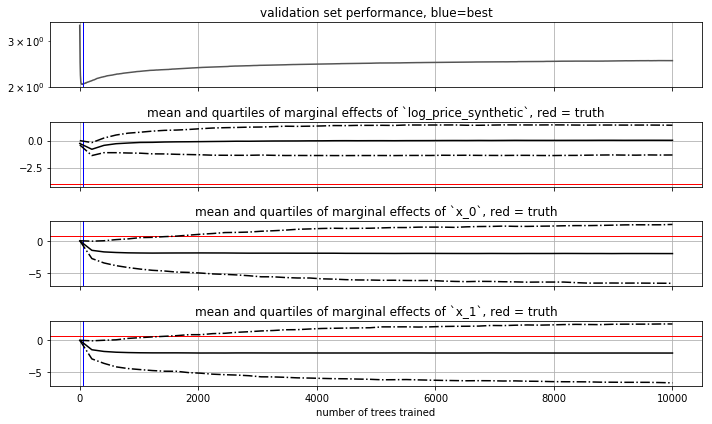

In [28]:
fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
# plot performance
ax = axes[0]
ax.grid()
perfs = eval_results['val']['rmse']
best_num_trees = np.argmin(perfs)
ax.plot(eval_results['val']['rmse'], color='#555555')
ax.axvline(best_num_trees, color='blue', linewidth=1)
ax.set_yscale('log')
ax.set_title("validation set performance, blue=best")

# plot marginal effects
for i,c in enumerate(desc_df.columns):
    tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
    ax = axes[i+1]
    ax.grid()
    # plot the true marginal effects
    if c=='log_price_synthetic':
        true_mfx = ivsim.log_sales_coefs.loc['log_price']
    else:
        true_mfx = ivsim.log_sales_coefs.loc[c]
    ax.axhline(true_mfx, color='red', linewidth=1)
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    # plot the model implied marignal effects
    ax.plot(tmp_df['mean'], color='black', linestyle='-')
    ax.plot(tmp_df['25%'], color='black', linestyle='-.')
    ax.plot(tmp_df['75%'], color='black', linestyle='-.')
    ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
plt.xlabel("number of trees trained")
plt.tight_layout()

In [ ]:
# ok, so extremely not-consistent

# ok, now let's try the custom objective

In [13]:

num_iters = 10000
print_every = max(num_iters//20, 10)
print(num_iters, print_every)

# try training
params = {
    'num_threads':4,
    'objective': None,
    'metric': None,
    'num_leaves': 5,
    'learning_rate': 0.2,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_delta_step':.1,
    'min_gain_to_split':10,
}
eval_results={}
gbm2 = lgb.train(params, train_set=dat_train, valid_sets=[dat_train, dat_val], valid_names=['train', 'val'],
                num_boost_round=num_iters, verbose_eval=print_every,
                fobj = lambda preds, dataset: custom_objectives.grouped_sse_loss_grad_hess(preds, dataset.label, dataset.grouper),
                feval = lambda preds, dataset: ('grouped sse',
                                                custom_objectives.grouped_sse_loss(preds, dataset.label, dataset.grouper),
                                                False),
                 callbacks=[lgb.record_evaluation(eval_results)]
                )

# look at some marginal effects
wrapped_gbm2 = model_wrapper.ModelWrapper(gbm2)
marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
marginal_fx.groupby('feature name').describe().transpose()

10000 500
[500]	train's grouped sse: 1.70528e+06	val's grouped sse: 769660
[1000]	train's grouped sse: 1.61289e+06	val's grouped sse: 808458
[1500]	train's grouped sse: 1.57734e+06	val's grouped sse: 825221
[2000]	train's grouped sse: 1.55725e+06	val's grouped sse: 840312
[2500]	train's grouped sse: 1.54558e+06	val's grouped sse: 850311
[3000]	train's grouped sse: 1.53907e+06	val's grouped sse: 857866
[3500]	train's grouped sse: 1.5338e+06	val's grouped sse: 863463
[4000]	train's grouped sse: 1.53072e+06	val's grouped sse: 865006
[4500]	train's grouped sse: 1.52811e+06	val's grouped sse: 870156
[5000]	train's grouped sse: 1.52569e+06	val's grouped sse: 868006
[5500]	train's grouped sse: 1.52375e+06	val's grouped sse: 869557
[6000]	train's grouped sse: 1.52219e+06	val's grouped sse: 868860
[6500]	train's grouped sse: 1.52039e+06	val's grouped sse: 869730
[7000]	train's grouped sse: 1.51923e+06	val's grouped sse: 870986
[7500]	train's grouped sse: 1.51813e+06	val's grouped sse: 870698
[8

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.788094     0.575938     0.460489
                std               9.208127     3.142578     2.969033
                min             -38.614154   -15.036677    -9.390947
                25%              -9.192302    -1.652446    -1.447928
                50%              -4.228282     0.605125     0.328834
                75%               1.528779     2.713907     2.330804
                max              31.259800    11.444552    11.045441

In [14]:
# generate time series of marginal effects
dfs_to_concat = []
for num_iteration in np.linspace(1,num_iters, 50, dtype=int):
#     print(num_iteration)
    mfx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
    tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                .reset_index().rename(columns={'index':'stat'})
    tmp_df.columns.name=None
    tmp_df['num_iteration'] = num_iteration
    tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
#     display(tmp_df)
    dfs_to_concat.append(tmp_df)
desc_df = pd.concat(dfs_to_concat)

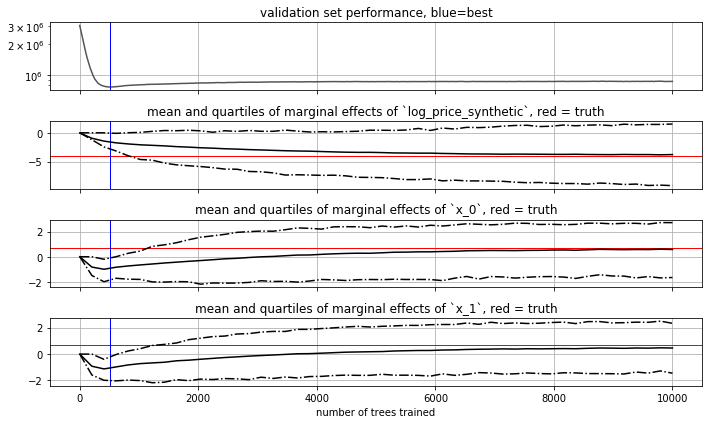

In [15]:
fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
# plot performance
ax = axes[0]
ax.grid()
perfs = eval_results['val']['grouped sse']
best_num_trees = np.argmin(perfs)
ax.plot(eval_results['val']['grouped sse'], color='#555555')
ax.axvline(best_num_trees, color='blue', linewidth=1)
ax.set_yscale('log')
ax.set_title("validation set performance, blue=best")

# plot marginal effects
for i,c in enumerate(desc_df.columns):
    tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
    ax = axes[i+1]
    ax.grid()
    # plot the true marginal effects
    if c=='log_price_synthetic':
        true_mfx = ivsim.log_sales_coefs.loc['log_price']
    else:
        true_mfx = ivsim.log_sales_coefs.loc[c]
    ax.axhline(true_mfx, color='red', linewidth=1)
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    # plot the model implied marignal effects
    ax.plot(tmp_df['mean'], color='black', linestyle='-')
    ax.plot(tmp_df['25%'], color='black', linestyle='-.')
    ax.plot(tmp_df['75%'], color='black', linestyle='-.')
    ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
plt.xlabel("number of trees trained")
plt.tight_layout()